# Power Analysis Summary

Power analyses typically involve three key parameters:

-Sample size (number of subjects per group),
-Effect size or expected difference between groups, and
-Statistical power (the probability of detecting a true effect, usually set at 80%).

Knowing any two of these parameters allows calculation of the third. In most studies, we typically estimate the required sample size based on an expected effect size (often drawn from prior literature) and a desired power level (commonly 80%). In the present case, the sample size was fixed in advance at 12 subjects per group (n₁ = n₂ = 12). Therefore, the goal of the analysis was to determine the statistical power given this sample size and various plausible differences between groups.

The outcome variable was the Visual Analog Scale (VAS) score, comparing patients with isolated REM Sleep Behavior Disorder (iRBD, without Parkinson’s disease) and patients with narcolepsy type 1 presenting RBD. Based on literature and clinical judgment, reasonable expected differences were translated into standardized mean differences (Cohen’s d) ranging from 0.5 to 2.0, max (i.e., a difference of half to 2 SDs).

My power calculations (two-sample, two-sided t-test, α = 0.05) suggest that:

-With d = 1.0 (a difference of one standard deviation), power is approximately 70%.
-With d = 0.5 (a difference of half a standard deviation), power is approximately 20%.

Power reaches ~80% for d ≈ 1.2, and exceeds 90% for d ≥ 1.4. But these are unlikely to be observed from a quick literature run.

Thus, with 12 subjects per group, the study would be adequately powered to detect large effects (≥1.2 SD) but underpowered for smaller, more likely effects (if any).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt     

In [4]:
from scipy import stats, optimize

In [5]:
n_per_group = 12
alpha = 0.05
two_sided = True
df = 2*n_per_group - 2

In [21]:
# Compute power as a function of different Cohen d's standardized mean differences from 0 to 2


def power_from_d(d, n=n_per_group, alpha=alpha):
    delta = d * np.sqrt(n/2.0)
    t_crit = stats.t.ppf(1 - alpha/2.0, df)
    cdf_pos = stats.nct.cdf(t_crit, df, delta)
    cdf_neg = stats.nct.cdf(-t_crit, df, delta)
    power = 1.0 - (cdf_pos - cdf_neg)
    return power

d_vals = np.round(np.linspace(0.5, 2.0, 151), 3)  # steps of 0.01 approx
power_vals = np.array([power_from_d(d) for d in d_vals])


In [22]:
# Find minimal d for 80% and 90% power
def find_min_d_for_power(target_power):
        f = lambda d: power_from_d(d) - target_power
        # bracket: [0, 5]
        try:
            root = optimize.brentq(f, 1e-6, 5.0)
            return root
        except Exception:
            # fallback to grid search
            ds = np.linspace(0, 5, 10001)
            p = np.array([power_from_d(dd) for dd in ds])
            idx = np.where(p >= target_power)[0]
            return ds[idx[0]] if len(idx)>0 else np.nan
    
d_80 = find_min_d_for_power(0.80)
d_90 = find_min_d_for_power(0.90)


In [23]:
# https://pmc.ncbi.nlm.nih.gov/articles/PMC6362482/#sec4
# https://pmc.ncbi.nlm.nih.gov/articles/PMC10196013/#tab3

# Given the papers above, expect a difference of maybe 1 to 3 in the VAS, max
sd_choices = [0.5, 1.0, 1.5, 2.0, 2.5, 3.5]
raw_diffs = np.arange(0, 5.1, 0.5)
rows = []

for sd in sd_choices:
    for raw in raw_diffs:
        d = raw/sd
        p = power_from_d(d)
        rows.append({
            "SD": sd,
            "RawDifference": raw,
            "Cohen_d": round(d, 3),
            "Power": round(p, 3)
        })

# Shows power as a function of the observed SD and RawDifference, expected an SD of 1 to 2, a RawDiference Less than 2 or 3 maybe?
df_table = pd.DataFrame(rows)


In [24]:
# Do the reverse and ask what is the minimal detectable difference at SDs for 80% and 90%
rows2 = []

for sd in sd_choices:
    raw80 = d_80 * sd
    raw90 = d_90 * sd
    rows2.append({"SD": sd, "d_for_80%": round(d_80,3), "RawDiff_for_80%": round(raw80,3),
                  "d_for_90%": round(d_90,3), "RawDiff_for_90%": round(raw90,3)})
    
df_min_detect = pd.DataFrame(rows2)


In [25]:
df_min_detect # For an SD of 1 to 2, to have 80% power, you need an observed difference of about 2 in the VAS scale

,SD,d_for_80%,RawDiff_for_80%,d_for_90%,RawDiff_for_90%
0,0.5,1.197,0.598,1.385,0.693
1,1.0,1.197,1.197,1.385,1.385
2,1.5,1.197,1.795,1.385,2.078
3,2.0,1.197,2.394,1.385,2.770
4,2.5,1.197,2.992,1.385,3.463
5,3.5,1.197,4.189,1.385,4.848


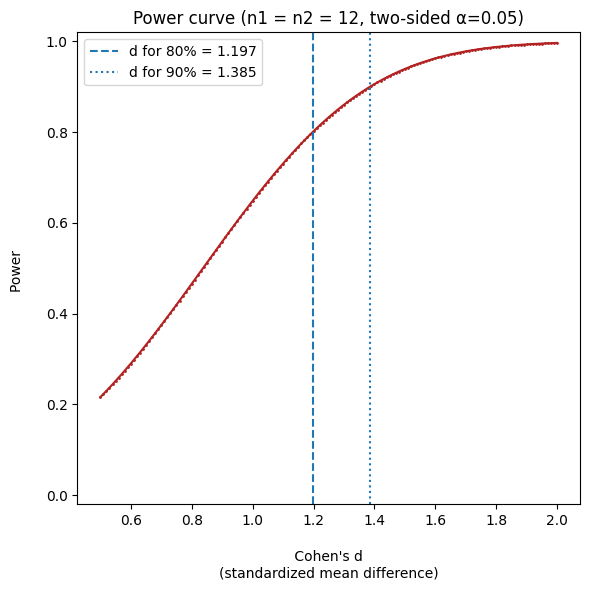

In [27]:
# Plot power curve
plt.figure(figsize=(6,6))
plt.plot(d_vals, power_vals, '-o', color="firebrick", markersize=1, linewidth=1.5)

plt.axvline(d_80, linestyle='--', label=f'd for 80% = {d_80:.3f}')
plt.axvline(d_90, linestyle=':', label=f'd for 90% = {d_90:.3f}')
plt.xlabel("\n Cohen's d \n(standardized mean difference)")
plt.ylabel("Power \n")
plt.title(f"Power curve (n1 = n2 = {n_per_group}, two-sided α={alpha})")
plt.ylim(-0.02,1.02)
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()





In [12]:
print("Summary:")
print(f"- Sample size: {n_per_group} per group (total {2*n_per_group})")
print(f"- Two-sided alpha = {alpha}, df = {df}")
print(f"- Minimal detectable Cohen's d for 80% power: {d_80:.4f}")
print(f"- Minimal detectable Cohen's d for 90% power: {d_90:.4f}")
print("\nTable 'df_min_detect' contains approximate raw differences required for given SDs to reach 80%/90% power.")
print("Minimal detectable raw differences for several SD assumptions \n", df_min_detect)

Summary:
- Sample size: 12 per group (total 24)
- Two-sided alpha = 0.05, df = 22
- Minimal detectable Cohen's d for 80% power: 1.1968
- Minimal detectable Cohen's d for 90% power: 1.3852

Table 'df_min_detect' contains approximate raw differences required for given SDs to reach 80%/90% power.
Minimal detectable raw differences for several SD assumptions 
     SD  d_for_80%  RawDiff_for_80%  d_for_90%  RawDiff_for_90%
0  0.5      1.197            0.598      1.385            0.693
1  1.0      1.197            1.197      1.385            1.385
2  1.5      1.197            1.795      1.385            2.078
3  2.0      1.197            2.394      1.385            2.770
4  2.5      1.197            2.992      1.385            3.463
5  3.5      1.197            4.189      1.385            4.848


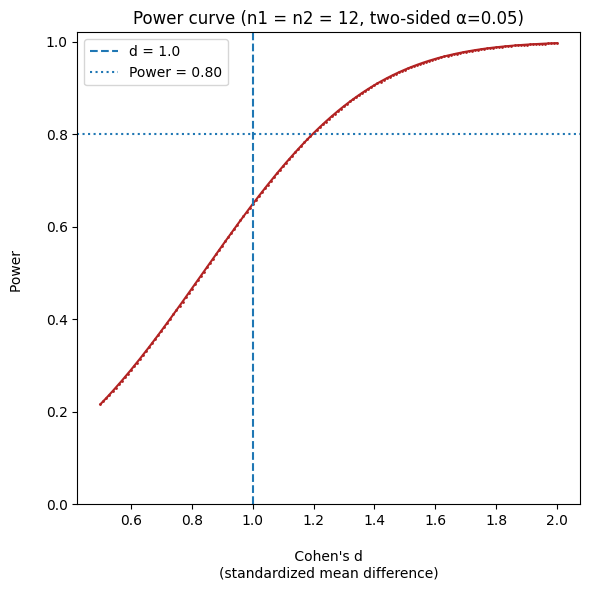

In [20]:
d_vals = np.round(np.linspace(0.5, 2.0, 151), 3)  # steps of 0.01 approx
power_vals = np.array([power_from_d(d) for d in d_vals])

# Create dataframe for display (selected points every 0.05)
mask = np.isin(d_vals, np.round(np.arange(0.5,2.01,0.05),3))
df_out = pd.DataFrame({"Cohen_d": d_vals[mask], "Power": np.round(power_vals[mask],3)})

# Plot
plt.figure(figsize=(6,6))
plt.plot(d_vals, power_vals, '-o', color="firebrick", markersize=1, linewidth=1.5)
plt.axvline(1.0, linestyle='--', label="d = 1.0")
plt.axhline(0.8, linestyle=':', label="Power = 0.80")
plt.xlabel("\n Cohen's d \n(standardized mean difference)")
plt.ylabel("Power \n")
plt.title(f"Power curve (n1 = n2 = {n_per_group}, two-sided α={alpha})")
plt.ylim(0,1.02)
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()



In [14]:
# Print a small summary 
print(f"Sample size: {n_per_group} per group (total {2*n_per_group}), df = {df}, α = {alpha}")
print("Selected values (Cohen's d -> Power):")
for d,p in zip(df_out['Cohen_d'], df_out['Power']):
    print(f"  d = {d:.2f} -> power = {p:.3f}")

Sample size: 12 per group (total 24), df = 22, α = 0.05
Selected values (Cohen's d -> Power):
  d = 0.50 -> power = 0.216
  d = 0.55 -> power = 0.252
  d = 0.60 -> power = 0.290
  d = 0.65 -> power = 0.331
  d = 0.70 -> power = 0.375
  d = 0.75 -> power = 0.420
  d = 0.80 -> power = 0.466
  d = 0.85 -> power = 0.512
  d = 0.90 -> power = 0.559
  d = 0.95 -> power = 0.604
  d = 1.00 -> power = 0.649
  d = 1.05 -> power = 0.691
  d = 1.10 -> power = 0.731
  d = 1.15 -> power = 0.768
  d = 1.20 -> power = 0.802
  d = 1.25 -> power = 0.833
  d = 1.30 -> power = 0.861
  d = 1.35 -> power = 0.885
  d = 1.40 -> power = 0.906
  d = 1.45 -> power = 0.924
  d = 1.50 -> power = 0.939
  d = 1.55 -> power = 0.952
  d = 1.60 -> power = 0.963
  d = 1.65 -> power = 0.971
  d = 1.70 -> power = 0.978
  d = 1.75 -> power = 0.984
  d = 1.80 -> power = 0.988
  d = 1.85 -> power = 0.991
  d = 1.90 -> power = 0.993
  d = 1.95 -> power = 0.995
  d = 2.00 -> power = 0.997
